<a href="https://colab.research.google.com/github/Chanuka-ChandraYapa/Kode-Blitz_SpaceXplore/blob/main/Kode_Blitz_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datathon-Dataset.zip

In [ ]:
import  warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
ROOT_DIR = "/content/Datathon-Dataset"
no_of_images = {}
for dir in os.listdir(ROOT_DIR):
  no_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [ ]:
def dataFolder(path, split):
  if not os.path.exists("./"+path):
    os.mkdir("./" + path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+ path + "/" + dir)
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size = (math.floor(split*no_of_images[dir])-5), replace= False):
        o = os.path.join(ROOT_DIR,dir,img)
        D = os.path.join("./"+ path, dir)
        shutil.move(o, D)
  else:
    print(f"{path} folder exists")

In [ ]:
dataFolder("train", 0.7)
dataFolder("val", 0.15)
dataFolder("test",0.15)

In [ ]:
#import Keral module
from keras.applications import VGG16
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Define the number of classes
num_classes = 4

# Create a custom top model
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(num_classes, activation='softmax')(top_model)

In [ ]:
# Combine the base model and top model
model = Model(inputs=base_model.input, outputs=top_model)


In [ ]:
# Fine-tune more layers of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True


In [ ]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# Callbacks
mc = ModelCheckpoint(filepath="./bestmodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

callbacks = [mc, es, reduce_lr]

In [ ]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

In [ ]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_accuracy:.4f}")


Found 2235 images belonging to 4 classes.
Found 462 images belonging to 4 classes.
Found 462 images belonging to 4 classes.
Epoch 1/100
70/70 [==============================] - ETA: 0s - loss: 1.4801 - accuracy: 0.4550
Epoch 1: val_accuracy improved from -inf to 0.63853, saving model to ./bestmodel.h5
70/70 [==============================] - 50s 707ms/step - loss: 1.4801 - accuracy: 0.4550 - val_loss: 0.9776 - val_accuracy: 0.6385 - lr: 1.0000e-05
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 1.0826 - accuracy: 0.6103
Epoch 2: val_accuracy improved from 0.63853 to 0.69697, saving model to ./bestmodel.h5
70/70 [==============================] - 39s 549ms/step - loss: 1.0826 - accuracy: 0.6103 - val_loss: 0.7676 - val_accuracy: 0.6970 - lr: 1.0000e-05
Epoch 3/100
70/70 [==============================] - ETA: 0s - loss: 0.8424 - accuracy: 0.7208
Epoch 3: val_accuracy improved from 0.69697 to 0.74242, saving model to ./bestmodel.h5
70/70 [============================

In [ ]:
from keras.models import load_model

model = load_model("/content/bestmodel.h5")

15/15 [==============================] - 2s 128ms/step - loss: 0.1961 - accuracy: 0.9502
Validation accuracy: 0.9502164721488953
70/70 [==============================] - 34s 475ms/step - loss: 0.0731 - accuracy: 0.9758
Training accuracy: 0.9758388996124268


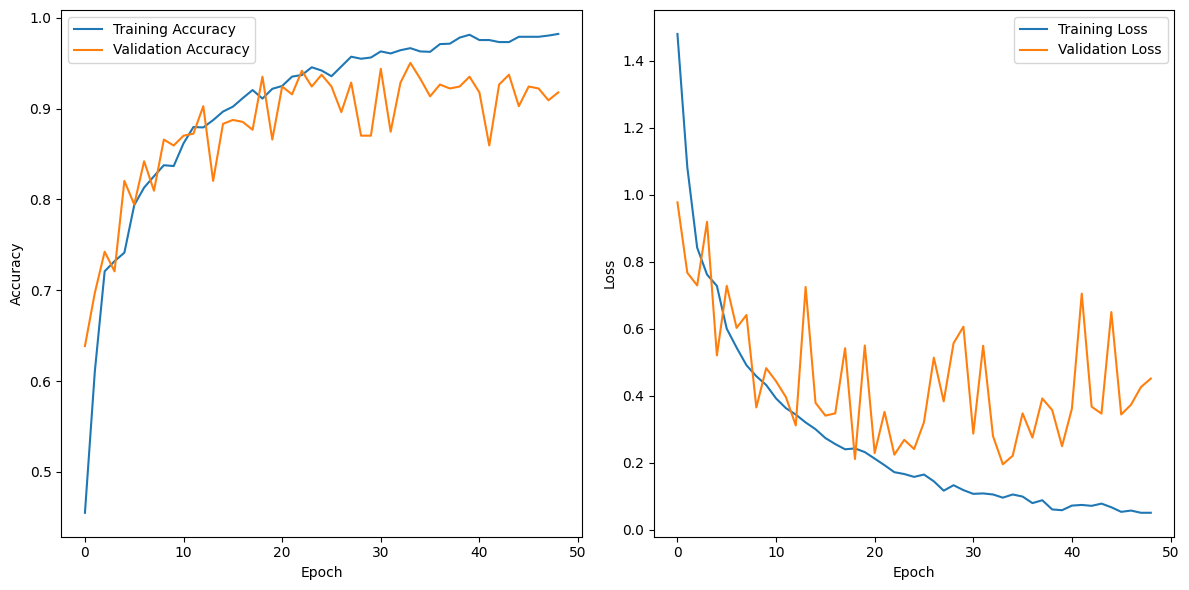

Overfitting rate: 0.026256821155323795


In [ ]:
import matplotlib.pyplot as plt

# Evaluate validation accuracy
val_loss, val_acc = model.evaluate(val_generator, steps=len(val_generator))
print("Validation accuracy:", val_acc)

# Evaluate training accuracy
train_loss, train_acc = model.evaluate(train_generator, steps=len(train_generator))
print("Training accuracy:", train_acc)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate overfitting rate
overfitting_rate = 1 - val_acc / train_acc
print("Overfitting rate:", overfitting_rate)

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Load the trained model
model = load_model("/content/bestmodel.h5")

# Load and preprocess the input image
image_path = "/content/Datathon-Dataset/category3_tumor/pt_img (539).jpg"  # Change to the actual path
img = load_img(image_path, target_size=(224, 224))
input_arr = img_to_array(img) / 255.0
input_arr = np.expand_dims(input_arr, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict(input_arr)

# Interpret the predictions
class_labels = ["cancer_category_1", "cancer_category_2", "cancer_category_3", "no cancer"]
predicted_class = class_labels[np.argmax(predictions)]

print(f"The predicted class is: {predicted_class}")